In [16]:
# Thoomas Goldman 2023
# DOLPHINN
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle 

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.training import Scheduler, Restarter, Restorer
from DOLPHINN.metrics import FinalDr, FinalDv
from DOLPHINN.callbacks import StoreAnimationData
from DOLPHINN import plotting
from DOLPHINN import utils

In [10]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10

rp = AU
ra = AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(1+e)*np.sqrt(mu/r0) 
initial_state = np.array([r0, vr0, vt0])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 1*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 3
neurons = 3
hidden_layers = 3
layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension]
layer_size = [1, 3, 3]
              
data = {"initial_state": initial_state,
        "mu": mu,
        "m": m,
        "a": a,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "relu",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

In [11]:
# Create problem
problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensional",
                    output_transform = "InitialStateLayer", 
                    display_every = 1000)
restarter = Restarter([(1e-2, 2000)])
schedule = Scheduler([(1e-4, 2000)])
problem.train([restarter, schedule])

[DOLPHINN] Using time-dependent random seed: 20230713115622

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.002489 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [0.00e+00, 0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [0.00e+00, 0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [0.00e+00, 0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 0.00e+00
  test loss: 0.00e+00
  test metric: []

'train' took 2.622973 s


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.022805 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [0.00e+00, 0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [0.00e+00, 0.00e+00, 0.00e+00]    [0.00e+0

In [113]:
schedule = Scheduler([(1e-4, 5000)])
problem.train([schedule])


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.039455 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [3.51e-06, 4.08e-06, 1.57e-05]    [3.54e-06, 3.99e-06, 1.53e-05]    []  
11000     [3.50e-06, 4.17e-06, 1.50e-05]    [3.53e-06, 4.05e-06, 1.47e-05]    []  
12000     [3.41e-06, 4.32e-06, 1.41e-05]    [3.44e-06, 4.18e-06, 1.38e-05]    []  
13000     [3.33e-06, 4.43e-06, 1.33e-05]    [3.35e-06, 4.26e-06, 1.31e-05]    []  
14000     [3.26e-06, 4.49e-06, 1.28e-05]    [3.29e-06, 4.31e-06, 1.25e-05]    []  
15000     [3.20e-06, 4.54e-06, 1.23e-05]    [3.23e-06, 4.33e-06, 1.21e-05]    []  

Best model at step 15000:
  train loss: 2.01e-05
  test loss: 1.97e-05
  test metric: []

'train' took 9.659272 s

[DOLPHINN] This training ['Scheduler'] took 9.7 s
[DOLPHINN] The entire training so far took: 33.23 s


In [15]:
d = problem.model.state_dict()
for key in d.keys(): 
    print(d[key])

<tf.Variable 'pfnn_5/dense_5/kernel:0' shape=(1, 3) dtype=float32, numpy=array([[-0.18226254, -0.8684468 , -0.252216  ]], dtype=float32)>
<tf.Variable 'pfnn_5/dense_5/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>
<tf.Variable 'pfnn_5/dense_6/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.14881675, -0.70908386, -0.20593353],
       [-1.0169883 ,  0.35179728, -0.18084691],
       [-0.3030083 ,  0.19232582, -0.5085721 ]], dtype=float32)>
<tf.Variable 'pfnn_5/dense_6/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>


[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.0025 s


C:\Users\thoma\Documents\Master_Space_Exploration\Thesis_Space\DOLPHINN\Experiments\..\DOLPHINN\plotting.py:52: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[0].set_yscale("log")
C:\Users\thoma\Documents\Master_Space_Exploration\Thesis_Space\DOLPHINN\Experiments\..\DOLPHINN\plotting.py:53: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].set_yscale("log")


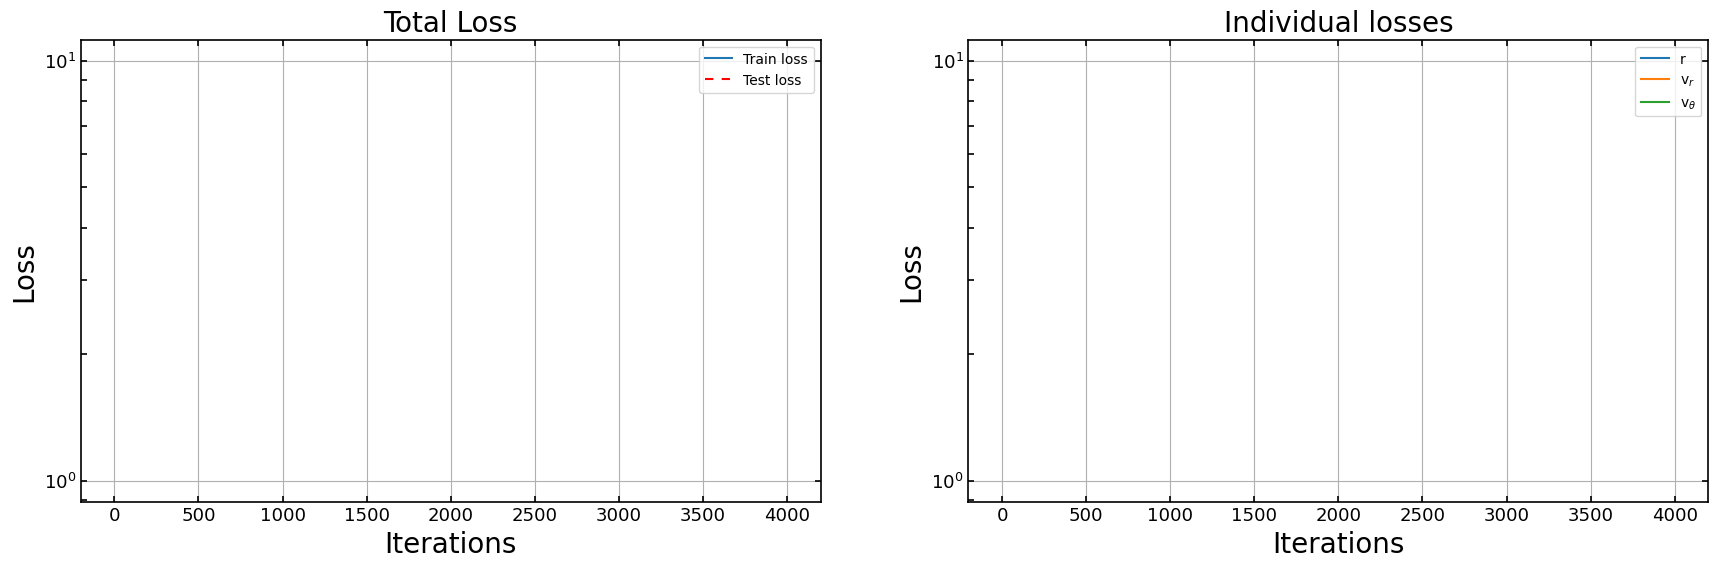

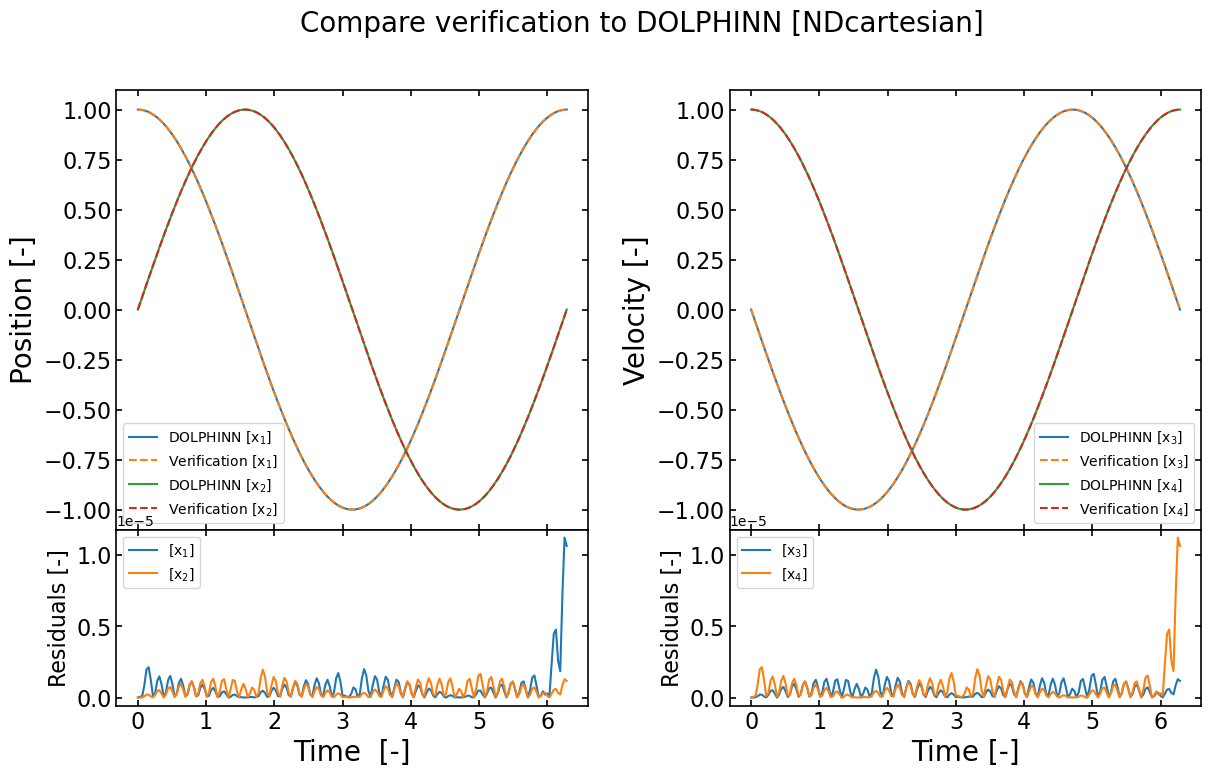

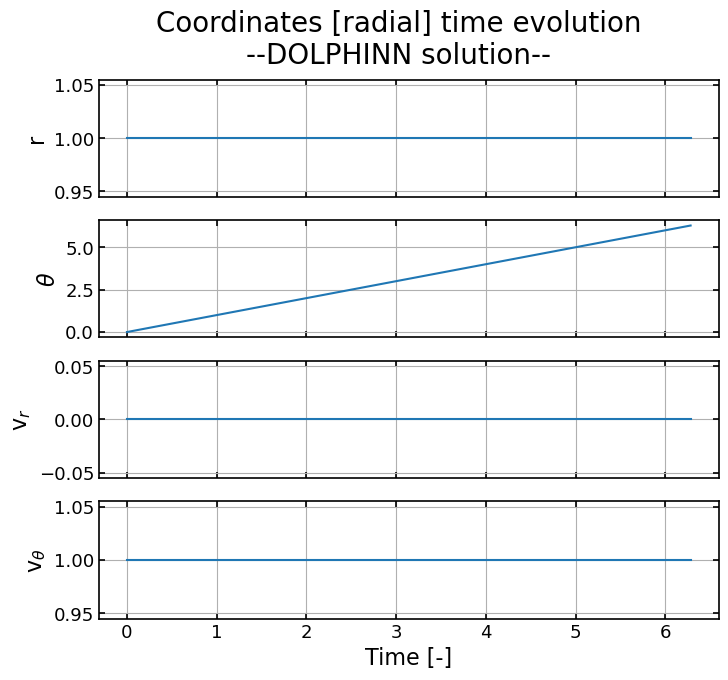

In [12]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=False)  
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial", plot_control = False)